In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
dataset = pd.read_csv('./digit_data.csv')

In [3]:
# converting dataframe 'dataset' into numpy array
dataset_np = dataset.values
no_data, no_features = dataset_np.shape

# shuffle the content of numpy array
np.random.shuffle(dataset_np)

test_set = dataset_np[:2100].T
y_test = test_set[0, :]
X_test = test_set[1:, :] / 255

valid_set = dataset_np[2100:4200].T
y_valid = valid_set[0, :]
X_valid = valid_set[1:, :] / 255

train_set = dataset_np[4200:].T
y_train = train_set[0, :]
X_train = train_set[1:, :] / 255

In [4]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(784, 37800) (37800,)
(784, 2100) (2100,)
(784, 2100) (2100,)


In [82]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def one_hot_encode_array(digits):
    if not np.all((digits >= 0) & (digits <= 9)):
        raise ValueError("Digits must be in the range 0-9.")
    num_digits = len(digits)
    encoding = np.zeros((num_digits, 10))
    encoding[np.arange(num_digits), digits] = 1
    return encoding.T

In [85]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation_functions = None, weight_init = "random", dropout_probs=None):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.dropout_probs = dropout_probs
        self.parameters = self.initialize_parameters(weight_init)
        self.activation_functions = activation_functions

        self.hyperparameters = {
            "layer_sizes": layer_sizes,
            "activation_functions": activation_functions,
            "weight_init": weight_init,
            "dropout_probs": dropout_probs
        }

        saving_statement = f"\n\nlayer_size: {layer_sizes}\tactivation_functions: {activation_functions}\tweight_init: {weight_init}\tdropout_probs: {dropout_probs}\n\n"
        saving_statement += "Train Loss\tTrain Accuracy\tValid Loss\tValid Accuracy\n"
#         with open("/content/output_statement.txt", "a") as file:
#             file.write(saving_statement)

    def initialize_parameters(self, weight_init):
        parameters = {}
        for layer in range(1, self.num_layers):
            if weight_init == "random":
                parameters[f'W{layer}'] = np.random.uniform(-0.5, 0.5, (self.layer_sizes[layer], self.layer_sizes[layer-1]))
            elif weight_init == "kaiming":
                parameters[f'W{layer}'] = np.random.randn(self.layer_sizes[layer], self.layer_sizes[layer-1]) * np.sqrt(2.0 / self.layer_sizes[layer-1])
            elif weight_init == "xavier":
                parameters[f'W{layer}'] = np.random.randn(self.layer_sizes[layer], self.layer_sizes[layer-1]) * np.sqrt(1.0 / self.layer_sizes[layer-1])
            else:
                raise ValueError("Invalid weight initialization method.")

            parameters[f'b{layer}'] = np.random.uniform(-0.5, 0.5, (self.layer_sizes[layer], 1))
        return parameters

    def forward_propagation(self, X):
        A = X
        cache = {}
        for layer in range(1, self.num_layers):
            Z = np.dot(self.parameters[f'W{layer}'], A) + self.parameters[f'b{layer}']
            if self.dropout_probs and layer < self.num_layers - 1:
                # Apply dropout if specified (excluding the output layer)
                D = (np.random.rand(*Z.shape) < (1 - self.dropout_probs[layer-1])).astype(int)
                A = self.apply_activation(Z, self.activation_functions[layer - 1]) * D / (1 - self.dropout_probs[layer-1])
                cache[f'D{layer}'] = D
            else:
                A = self.apply_activation(Z, self.activation_functions[layer - 1])
            cache[f'Z{layer}'] = Z
            cache[f'Z{layer}'] = Z
            cache[f'A{layer}'] = A
        return cache

    def backward_propagation(self, cache, X, Y):
        m = X.shape[1]
        gradients = {}
        cache['A0'] = X
        for layer in range(self.num_layers - 1, 0, -1):
            if layer == self.num_layers - 1:
                dZ = cache['A' + str(layer)] - Y
            else:
                if self.dropout_probs:
                    dZ = np.dot(self.parameters[f'W{layer+1}'].T, gradients[f'dZ{layer+1}']) * (cache[f'D{layer}'] / (1 - self.dropout_probs[layer-1]))
                else:
                    dZ = np.dot(self.parameters[f'W{layer+1}'].T, gradients[f'dZ{layer+1}']) * relu(cache[f'Z{layer}'])
            dW = np.dot(dZ, cache['A' + str(layer-1)].T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            gradients[f'dZ{layer}'] = dZ
            gradients[f'dW{layer}'] = dW
            gradients[f'db{layer}'] = db
        return gradients

    def update_parameters(self, gradients, learning_rate):
        for layer in range(1, self.num_layers):
            self.parameters[f'W{layer}'] -= learning_rate * gradients[f'dW{layer}']
            self.parameters[f'b{layer}'] -= learning_rate * gradients[f'db{layer}']

    def train(self, X_train, y_train, X_valid, y_valid, learning_rate, num_iterations):
        y_train = one_hot_encode_array(y_train)
        if y_train.shape != (self.layer_sizes[-1], X_train.shape[1]):
            raise ValueError(f"Shape mismatch: Y should have shape {(self.layer_sizes[-1], X_train.shape[1])} when using one-hot encoding.")

        precision_list, recall_list, avg_precision_list = [], [], []
        for i in range(num_iterations):
            cache = self.forward_propagation(X_train)
            gradients = self.backward_propagation(cache, X_train, y_train)
            self.update_parameters(gradients, learning_rate)

            if i % 50 == 0:
                A2 = cache['A' + str(self.num_layers - 1)]

                train_loss = self.categorical_cross_entropy(A2, y_train)
                test_loss = self.categorical_cross_entropy(self.predict(X_valid), one_hot_encode_array(y_valid))

                train_accuracy = self.compute_accuracy(A2, y_train)
                test_accuracy = self.compute_accuracy(self.predict(X_valid), one_hot_encode_array(y_valid))

                print(f"Iteration: {i}\tTraining Loss: {train_loss:.4f}\tTraining Accuracy: {train_accuracy:.2f}% \
                Validation Loss: {test_loss:.4f}\tValidation Accuracy: {test_accuracy:.2f} %")

                saving_statement = f"NXZ {train_loss:.4f}\t{train_accuracy:.4f}\t{test_loss:.4f}\t{test_accuracy:.4f}\n"
#                 with open("/content/output_statement.txt", "a") as file:
#                     file.write(saving_statement)

#         with open("/content/output_statement.txt", "a") as file:
#             file.write("*"*50)


    def categorical_cross_entropy(self, A, Y):
        m = Y.shape[1]
        loss = -np.sum(Y * np.log(A + 1e-15)) / m
        return loss

    def test(self, X_test, Y_test):
        cache = self.forward_propagation(X_test)
        A2 = cache['A' + str(self.num_layers - 1)]
        accuracy = self.compute_accuracy(A2, one_hot_encode_array(Y_test))
        print(f"Test Accuracy: {accuracy:.2f} %")
        return accuracy


    def predict(self, X):
        cache = self.forward_propagation(X)
        A2 = cache['A' + str(self.num_layers - 1)]
        return A2

    def compute_accuracy(self, A, Y):
        predictions = np.argmax(A, axis=0)
        ground_truth = np.argmax(Y, axis=0)
        return np.sum(predictions == ground_truth) / Y.shape[1]

    def apply_activation(self, Z, activation_function):
        if activation_function == "sigmoid":
            return sigmoid(Z)
        elif activation_function == "tanh":
            return tanh(Z)
        elif activation_function == "relu":
            return relu(Z)
        elif activation_function == 'softmax':
            return softmax(Z)
        else:
            raise ValueError("Invalid activation function.")

    def save_model(self, filename):
        model_data = {
            "hyperparameters": self.hyperparameters,
            "parameters": self.parameters
        }
        with open(filename, 'wb') as file:
            pickle.dump(model_data, file)

    def compute_precision_recall(self, X_test, Y_test):
        cache = self.forward_propagation(X_test)
        A2 = cache['A' + str(self.num_layers - 1)]

        # You need to calculate precision and recall for each class separately
        precision_list, recall_list, avg_precision_list = [], [], []

        for class_idx in range(self.layer_sizes[-1]):
            y_true = (Y_test == class_idx).astype(int)
            y_scores = A2.T[:, class_idx]
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            avg_precision = average_precision_score(y_true, y_scores)

            precision_list.append(precision)
            recall_list.append(recall)
            avg_precision_list.append(avg_precision)

        return precision_list, recall_list, avg_precision_list

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model_data = pickle.load(file)
        hyperparameters = model_data["hyperparameters"]
        parameters = model_data["parameters"]
        model = cls(**hyperparameters)  # Reconstruct the model with the same hyperparameters
        model.parameters = parameters  # Set the loaded parameters
        return model

In [7]:
with open('./main outputs.txt', 'r') as file:
    lines = file.readlines()

In [25]:
outputs = {
    "BEST_data": [],
    "MIDDLE_data": [],
    "WORST_data": []
}
placements = ['BEST', 'MIDDLE', 'WORST']
p_index = 0
for line in lines:
    if placements[p_index] in line:
        record_data = True
        continue
    elif '****' in line:
        record_data = False
        p_index += 1
        continue
    
    if record_data:
        t_ls, t_ac, v_ls, v_ac = line.split('\t')
        t_ls = float(t_ls.split(' ')[1])
        t_ac = float(t_ac)
        v_ls = float(v_ls)
        v_ac = float(v_ac.strip('\n'))
        outputs[f"{placements[p_index]}_data"].append([t_ls, t_ac, v_ls, v_ac])
    
for key in outputs.keys():
    outputs[key] = np.array(outputs[key])
    
    sole_data = outputs[key]
    training_loss = sole_data[:, 0]
    training_accuracy = sole_data[:, 1]
    valid_loss = sole_data[:, 2]
    valid_accuracy = sole_data[:, 3]
    temp_dict = {
        't_loss': training_loss, 
        't_accuracy': training_accuracy,
        'v_loss': valid_loss,
        'v_accuracy': valid_accuracy
    }
    outputs[key] = temp_dict

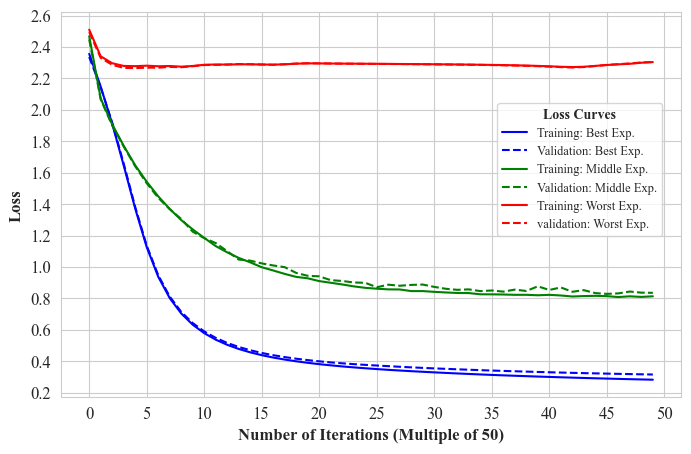

In [79]:
# Training Loss vs all the performances
font = FontProperties(family='Times New Roman', size = 9)
font_label = FontProperties(family='Times New Roman', size = 12, weight = "bold")
font_xticks = FontProperties(family='Times New Roman', size = 12)
font_yticks = FontProperties(family='Times New Roman', size = 12)

plt.figure(figsize = (8, 5))
sns.set_style('whitegrid')
plt.plot(outputs['BEST_data']['t_loss'], label = 'Training: Best Exp.', color = 'b')
plt.plot(outputs['BEST_data']['v_loss'], label = 'Validation: Best Exp.', color = 'b', linestyle = '--')

plt.plot(outputs['MIDDLE_data']['t_loss'], label = 'Training: Middle Exp.', color = 'g')
plt.plot(outputs['MIDDLE_data']['v_loss'], label = 'Validation: Middle Exp.', color = 'g', linestyle = '--')

plt.plot(outputs['WORST_data']['t_loss'], label = 'Training: Worst Exp.', color = 'r')
plt.plot(outputs['WORST_data']['v_loss'], label = 'validation: Worst Exp.', color = 'r', linestyle = '--')

plt.xlabel("Number of Iterations (Multiple of 50)", font = font_label)
plt.ylabel("Loss", font = font_label)

plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)

plt.xticks(font = font_xticks)
plt.yticks(font = font_yticks)
legend = plt.legend(loc = 'best', prop = font, bbox_to_anchor = (0.98, 0.78))
legend.set_title("Loss Curves", prop = {'size': 10, 'weight': 'bold', 'family': 'Times New Roman'})
plt.savefig("./Figures/1_training_losses.png", dpi = 300, bbox_inches = 'tight')
plt.show()

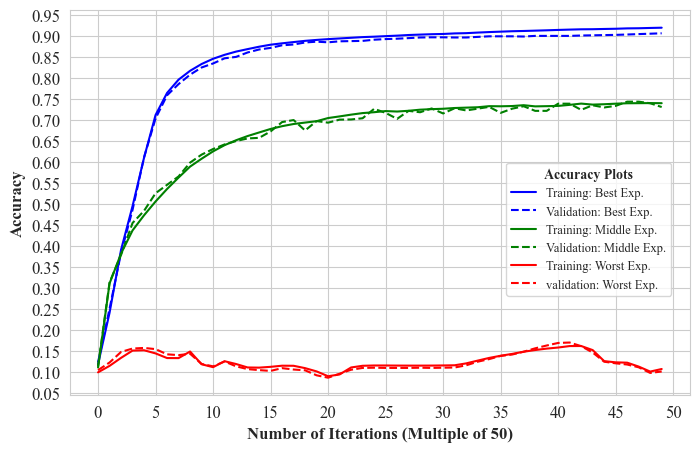

In [81]:
plt.figure(figsize = (8, 5))
sns.set_style('whitegrid')
plt.plot(outputs['BEST_data']['t_accuracy'], label = 'Training: Best Exp.', color = 'b')
plt.plot(outputs['BEST_data']['v_accuracy'], label = 'Validation: Best Exp.', color = 'b', linestyle = '--')

plt.plot(outputs['MIDDLE_data']['t_accuracy'], label = 'Training: Middle Exp.', color = 'g')
plt.plot(outputs['MIDDLE_data']['v_accuracy'], label = 'Validation: Middle Exp.', color = 'g', linestyle = '--')

plt.plot(outputs['WORST_data']['t_accuracy'], label = 'Training: Worst Exp.', color = 'r')
plt.plot(outputs['WORST_data']['v_accuracy'], label = 'validation: Worst Exp.', color = 'r', linestyle = '--')

plt.xlabel("Number of Iterations (Multiple of 50)", font = font_label)
plt.ylabel("Accuracy", font = font_label)

plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)

plt.xticks(font = font_xticks)
plt.yticks(font = font_yticks)
legend = plt.legend(loc = 'best', prop = font, bbox_to_anchor = (0.98, 0.62))
legend.set_title("Accuracy Plots", prop = {'size': 10, 'weight': 'bold', 'family': 'Times New Roman'})
plt.savefig("./Figures/2_training_accuracies.png", dpi = 300, bbox_inches = 'tight')
plt.show()

In [88]:
def build_classification_rep(y_pred, y_true):
    classification_rep = classification_report(y_true = y_true, y_pred = y_pred, output_dict=True)
    data = []
    accuracy_value = None
    for key, value in classification_rep.items():
        if key == 'accuracy':
            accuracy_value = "{:.2f}".format(value * 100)
        if not isinstance(value, float):
            row = [key] + [value[label] for label in value.keys()]
            data.append(row)

    columns = ['class', 'precision', 'recall', 'f1-score', 'support']
    df = pd.DataFrame(data, columns=columns)
    df['precision'] = df['precision'].apply(lambda x: "{:.2f}".format(x * 100))
    df['recall'] = df['recall'].apply(lambda x: "{:.2f}".format(x * 100))
    df['f1-score'] = df['f1-score'].apply(lambda x: "{:.2f}".format(x * 100))
    
    class_labels = {'0' : 'Good Client', '1' : 'Bad Client', 'macro avg' : 'Macro Avg.', 'weighted avg': 'Weighted Avg.'}
    df['class'] = df['class'].replace(class_labels)
    
    rows = 4
    cols = 5
    array_2d = [[0 for j in range(cols)] for i in range(rows)]
    
    for i, row in enumerate(df.iterrows()):
        array_2d[i][0] = row[1]['class']
        array_2d[i][1] = row[1]['precision']
        array_2d[i][2] = row[1]['recall']
        array_2d[i][3] = row[1]['f1-score']
        array_2d[i][4] = row[1]['support']
    
    output_latex = r'''\begin{table}[ht]
  \centering
  \caption{Classification Report: Logistic Regression Model}
  \label{tab:6}
  \begin{tabular}{|c|c|c|c|c|c|}
    \hline
    \\rule{0pt}{10pt}
    \textbf{Class} & \textbf{Precision} & \textbf{Recall} & \textbf{F1-Score} & \textbf{Support} \\
    \hline
    \\rule{0pt}{10pt}''' + f'''
     \f{array_2d[0][0]} & \f{array_2d[0][1]}\% & \f{array_2d[0][2]}\% & \f{array_2d[0][3]}\% & \f{array_2d[0][4]} \\
     \f{array_2d[1][0]} & \f{array_2d[1][1]}\% & \f{array_2d[1][2]}\% & \f{array_2d[1][3]}\% & \f{array_2d[1][4]} \\
    \hline''' + '''
    \\rule{0pt}{10pt}
    ''' + f'''
     Accuracy & & & {accuracy_value}\% & {array_2d[3][4]} \\
     \f{array_2d[2][0]} & \f{array_2d[2][1]}\% & \f{array_2d[2][2]}\% & \f{array_2d[2][3]}\% & \f{array_2d[2][4]} \\
     \f{array_2d[3][0]} & \f{array_2d[3][1]}\% & \f{array_2d[3][2]}\% & \f{array_2d[3][3]}\% & \f{array_2d[3][4]} \\
    ''' + '''
    \hline    
  \end{tabular}
  \\vspace{10pt}
\end{table}'''
    
    latex_string = output_latex.replace('\\n', '\n')
    latex_string = latex_string.replace('\\\\', '\\')
    latex_string = latex_string.replace('f', '', 2)
    latex_string = latex_string.replace('f', '', 3)
    
    return latex_string

In [92]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_18.pkl")
y_pred = np.argmax(loaded_model.predict(X_test), axis = 0)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       209
           1       0.92      0.83      0.87       272
           2       0.66      0.83      0.73       179
           3       0.76      0.69      0.72       237
           4       0.71      0.64      0.67       210
           5       0.65      0.62      0.64       220
           6       0.84      0.80      0.82       194
           7       0.78      0.77      0.78       213
           8       0.61      0.66      0.64       173
           9       0.64      0.73      0.68       193

    accuracy                           0.74      2100
   macro avg       0.74      0.74      0.74      2100
weighted avg       0.75      0.74      0.74      2100



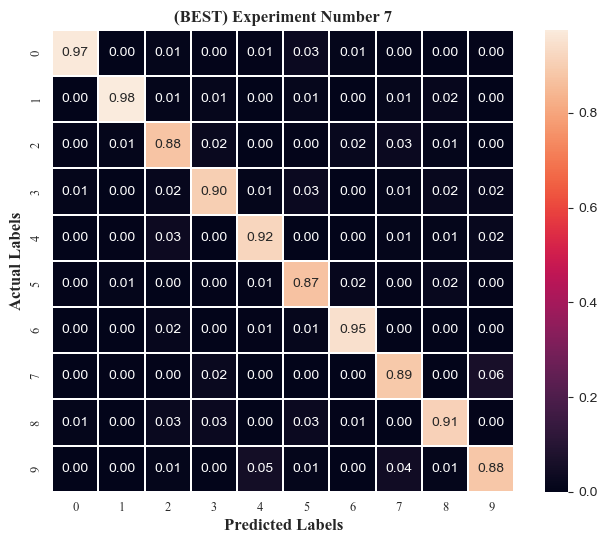

In [107]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_7.pkl")
y_pred = np.argmax(loaded_model.predict(X_test), axis = 0)

plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(y_pred, y_test, normalize = 'pred'), annot = True, fmt = "1.2f", linewidth = 0.01, square = True)
plt.xlabel("Predicted Labels", font = font_label)
plt.ylabel("Actual Labels", font = font_label)
plt.xticks(font = font)
plt.yticks(font = font)
plt.title("(BEST) Experiment Number 7", font = font_label)
plt.savefig("./Figures/3_best_CM.png", dpi = 300, bbox_inches = 'tight')
plt.show()

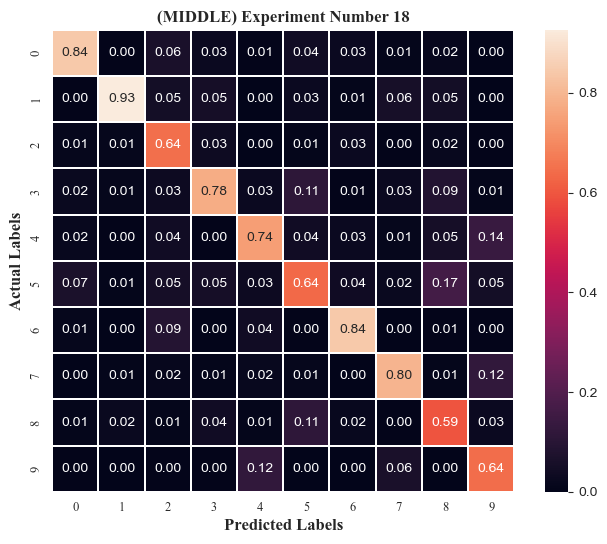

In [108]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_18.pkl")
y_pred = np.argmax(loaded_model.predict(X_test), axis = 0)

plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(y_pred, y_test, normalize = 'pred'), annot = True, fmt = "1.2f", linewidth = 0.01, square = True)
plt.xlabel("Predicted Labels", font = font_label)
plt.ylabel("Actual Labels", font = font_label)
plt.xticks(font = font)
plt.yticks(font = font)
plt.title("(MIDDLE) Experiment Number 18", font = font_label)
plt.savefig("./Figures/4_middle_CM.png", dpi = 300, bbox_inches = 'tight')
plt.show()

C:\Users\parzi\AppData\Local\Temp\ipykernel_4672\3093011564.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


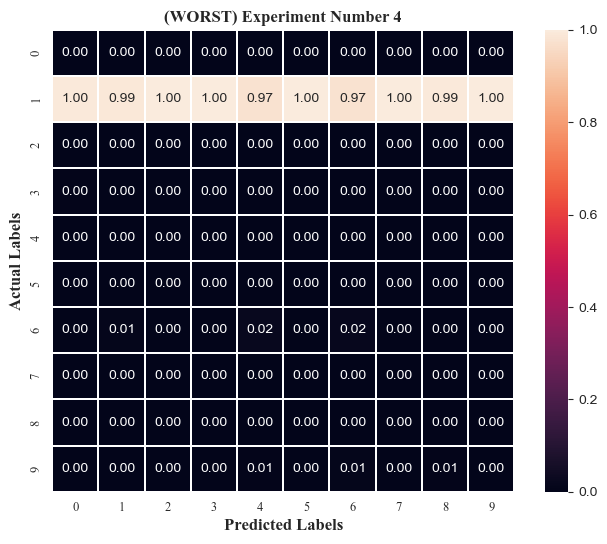

In [109]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_4.pkl")
y_pred = np.argmax(loaded_model.predict(X_test), axis = 0)

plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(y_pred, y_test, normalize = 'pred'), annot = True, fmt = "1.2f", linewidth = 0.01, square = True)
plt.xlabel("Predicted Labels", font = font_label)
plt.ylabel("Actual Labels", font = font_label)
plt.xticks(font = font)
plt.yticks(font = font)
plt.title("(WORST) Experiment Number 4", font = font_label)
plt.savefig("./Figures/5_worst_CM.png", dpi = 300, bbox_inches = 'tight')
plt.show()

#### Plotting PR-Curve for only Best and Middle Case

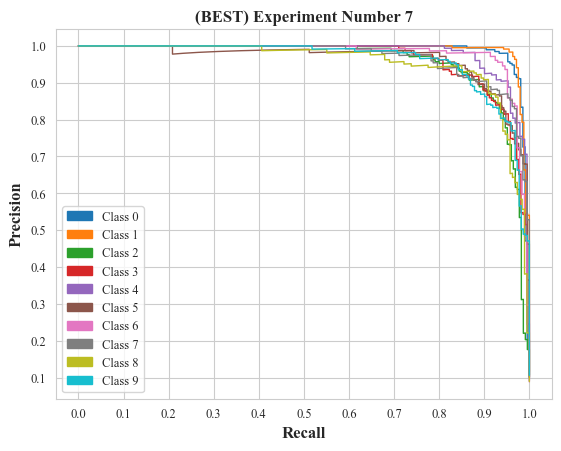

In [127]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_7.pkl")
precision, recall, avg_precision = loaded_model.compute_precision_recall(X_test, y_test)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for class_idx in range(10):
    plt.plot(recall[class_idx], precision[class_idx], color=colors[class_idx], lw=1, label=f'Class {class_idx}')

plt.xlabel('Recall', font = font_label)
plt.ylabel('Precision', font = font_label)
plt.title('(BEST) Experiment Number 7', font = font_label)

legend_patches = [mpatches.Patch(color=colors[class_idx], label=f'Class {class_idx}') for class_idx in range(10)]
plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)
plt.legend(handles=legend_patches, loc='best', prop = font)
plt.xticks(font = font)
plt.yticks(font = font)
plt.grid(True)
plt.savefig("./Figures/6_best_PR-curve.png", dpi = 300, bbox_inches = 'tight')
plt.show()

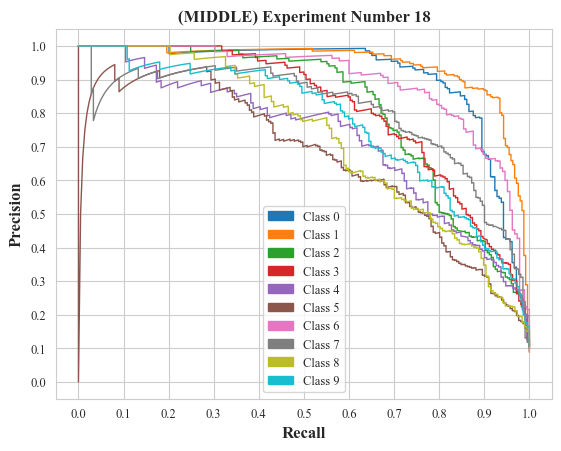

In [128]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_18.pkl")
precision, recall, avg_precision = loaded_model.compute_precision_recall(X_test, y_test)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for class_idx in range(10):
    plt.plot(recall[class_idx], precision[class_idx], color=colors[class_idx], lw=1, label=f'Class {class_idx}')

plt.xlabel('Recall', font = font_label)
plt.ylabel('Precision', font = font_label)
plt.title('(MIDDLE) Experiment Number 18', font = font_label)

legend_patches = [mpatches.Patch(color=colors[class_idx], label=f'Class {class_idx}') for class_idx in range(10)]
plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)
plt.legend(handles=legend_patches, loc='best', prop = font)
plt.xticks(font = font)
plt.yticks(font = font)
plt.grid(True)
plt.savefig("./Figures/7_middle_PR-curve.png", dpi = 300, bbox_inches = 'tight')
plt.show()

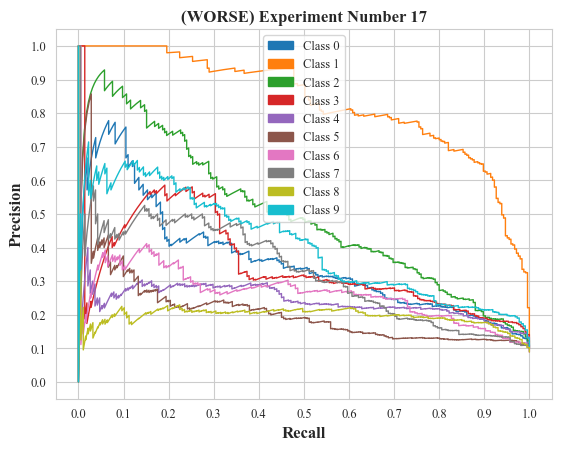

In [129]:
loaded_model = NeuralNetwork.load_model("./Models/saved_model_17.pkl")
precision, recall, avg_precision = loaded_model.compute_precision_recall(X_test, y_test)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for class_idx in range(10):
    plt.plot(recall[class_idx], precision[class_idx], color=colors[class_idx], lw=1, label=f'Class {class_idx}')

plt.xlabel('Recall', font = font_label)
plt.ylabel('Precision', font = font_label)
plt.title('(WORSE) Experiment Number 17', font = font_label)

legend_patches = [mpatches.Patch(color=colors[class_idx], label=f'Class {class_idx}') for class_idx in range(10)]
plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)
plt.legend(handles=legend_patches, loc='best', prop = font)
plt.xticks(font = font)
plt.yticks(font = font)
plt.grid(True)
plt.savefig("./Figures/8_worse_PR-curve.png", dpi = 300, bbox_inches = 'tight')
plt.show()

## PyTorch Implementation

In [26]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

batch_size = 1 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download = True)

batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[]):
        super(SimpleNN, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, hidden_layers[0] if hidden_layers else output_size))
        layers.append(nn.ReLU())

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_layers[-1] if hidden_layers else input_size, output_size))
        layers.append(nn.LogSoftmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [171]:
input_size = 784  
output_size = 10  

hidden_layers = [20, 10]

model = SimpleNN(input_size, output_size, hidden_layers)

criterion = nn.NLLLoss()  # Negative Log Likelihood Loss for classification
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop (you'll need to prepare your dataset and dataloaders)

for batch_inputs, batch_targets in tqdm(train_loader):
    optimizer.zero_grad() 
    batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
    outputs = model(batch_inputs)
    loss = criterion(outputs, batch_targets)
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:03<00:00, 939.42it/s]


In [173]:
model.eval()

predictions = []
true_labels = []

with torch.no_grad():  
    for batch_inputs, batch_targets in test_loader:
        batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)

        outputs = model(batch_inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(batch_targets.tolist())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy_score(true_labels, predictions)

0.8736

In [156]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.93      0.96      0.94      1010
           4       0.95      0.94      0.94       982
           5       0.92      0.93      0.92       892
           6       0.96      0.96      0.96       958
           7       0.89      0.97      0.93      1028
           8       0.97      0.89      0.93       974
           9       0.94      0.90      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [19]:
with open("./outputs_SGD.pkl", 'rb') as file:
    output_dict = pickle.load(file)

In [23]:
accuracy_list = np.array(output_dict['accuracy_list'])

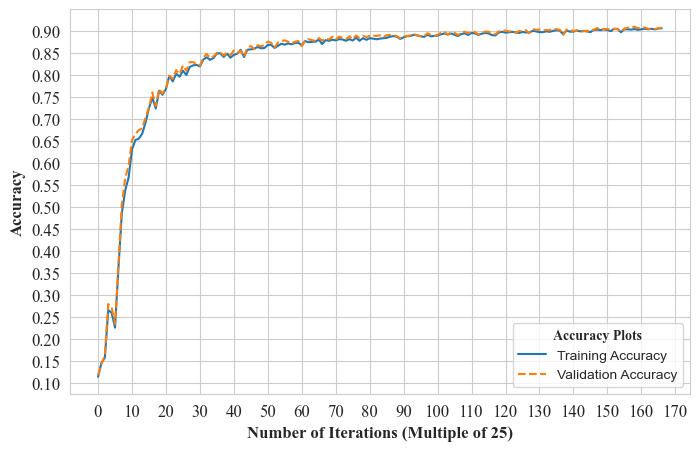

In [24]:

font = FontProperties(family='Times New Roman', size = 9)
font_label = FontProperties(family='Times New Roman', size = 12, weight = "bold")
font_xticks = FontProperties(family='Times New Roman', size = 12)
font_yticks = FontProperties(family='Times New Roman', size = 12)

plt.figure(figsize = (8, 5))
sns.set_style('whitegrid')
plt.plot(accuracy_list[:, 0], label = 'Training Accuracy')
plt.plot(accuracy_list[:, 1], label = 'Validation Accuracy', linestyle = '--')

plt.xlabel("Number of Iterations (Multiple of 25)", font = font_label)
plt.ylabel("Accuracy", font = font_label)

plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)

plt.xticks(font = font_xticks)
plt.yticks(font = font_yticks)
legend = plt.legend(loc = 'best')
legend.set_title("Accuracy Plots", prop = {'size': 10, 'weight': 'bold', 'family': 'Times New Roman'})
plt.savefig("./Figures/9_training_accuracies.png", dpi = 300, bbox_inches = 'tight')
plt.show()

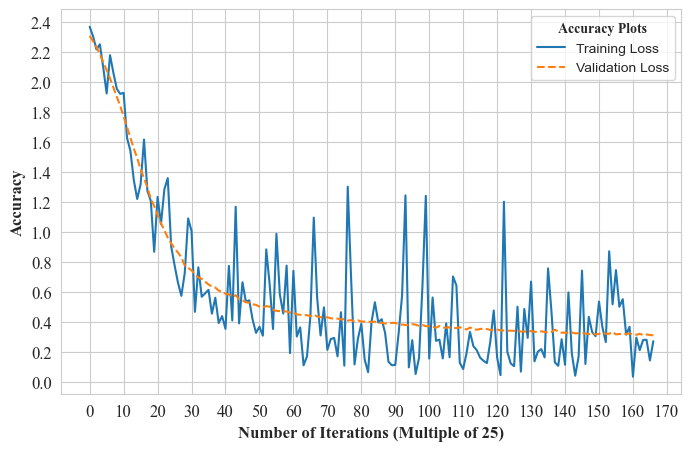

In [25]:
accuracy_list = np.array(output_dict['loss_list'])
font = FontProperties(family='Times New Roman', size = 9)
font_label = FontProperties(family='Times New Roman', size = 12, weight = "bold")
font_xticks = FontProperties(family='Times New Roman', size = 12)
font_yticks = FontProperties(family='Times New Roman', size = 12)

plt.figure(figsize = (8, 5))
sns.set_style('whitegrid')
plt.plot(accuracy_list[:, 0], label = 'Training Loss')
plt.plot(accuracy_list[:, 1], label = 'Validation Loss', linestyle = '--')

plt.xlabel("Number of Iterations (Multiple of 25)", font = font_label)
plt.ylabel("Accuracy", font = font_label)

plt.locator_params(axis='x', nbins = 20) 
plt.locator_params(axis='y', nbins = 20)

plt.xticks(font = font_xticks)
plt.yticks(font = font_yticks)
legend = plt.legend(loc = 'best')
legend.set_title("Accuracy Plots", prop = {'size': 10, 'weight': 'bold', 'family': 'Times New Roman'})
plt.savefig("./Figures/10_train_vs_validation_losses.png", dpi = 300, bbox_inches = 'tight')
plt.show()

#### Inferencing with Saved Model

In [38]:
dataset = pd.read_csv('./digit_data.csv')
dataset = dataset.sample(frac = 1, random_state = 69)

test_set = dataset.iloc[:2100]
valid_set = dataset.iloc[2100:4200]
train_set = dataset.iloc[4200:]

class CustomDataset(Dataset):
    def __init__(self, set_df):
        self.dataframe = set_df
        self.labels = self.dataframe.iloc[:, 0]
        self.data = self.dataframe.iloc[:, 1:] 
        self.data = self.data / 255

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        labels_ = self.labels.iloc[idx]
        sample = {
            'data': torch.Tensor(self.data.iloc[idx].values),
            'label': torch.Tensor([int(labels_)])
        }
        sample['label'] = sample['label'].to(torch.int64)
        return sample
    
batch_size = 8
train_dataset = CustomDataset(train_set)
valid_dataset = CustomDataset(valid_set)
test_dataset = CustomDataset(test_set)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [39]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
input_size = 784  
output_size = 10  

hidden_layers = [20]
model = SimpleNN(input_size, output_size, hidden_layers)
model.load_state_dict(torch.load("./saved_model.bin",map_location=torch.device('cpu')))

<All keys matched successfully>

In [51]:
model.eval()

predictions = []
true_labels = []

model = model.to(get_device())

with torch.no_grad():
    for batch_inputs in test_dataloader:
        data = batch_inputs['data'].to(get_device())
        labels = batch_inputs['label'].view(-1).to(get_device())

        data = data.view(data.size(0), -1)
        outputs = model(data)
        value, predicted = torch.max(outputs, 1)
        print(value, predicted)
        break
        predictions.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())
        

predictions = np.array(predictions)
true_labels = np.array(true_labels)

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

tensor([-0.0004, -0.0018, -0.0017, -0.0040, -0.0833, -0.0229, -0.0008, -0.0705]) tensor([4, 6, 3, 1, 5, 8, 5, 6])
Accuracy: nan%


C:\Users\parzi\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\parzi\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [42]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       193
           1       0.96      0.99      0.98       256
           2       0.99      0.94      0.96       217
           3       0.91      0.96      0.93       207
           4       0.94      0.93      0.93       209
           5       0.93      0.92      0.92       197
           6       0.96      0.98      0.97       189
           7       0.98      0.98      0.98       202
           8       0.94      0.93      0.94       220
           9       0.94      0.91      0.93       210

    accuracy                           0.95      2100
   macro avg       0.95      0.95      0.95      2100
weighted avg       0.95      0.95      0.95      2100



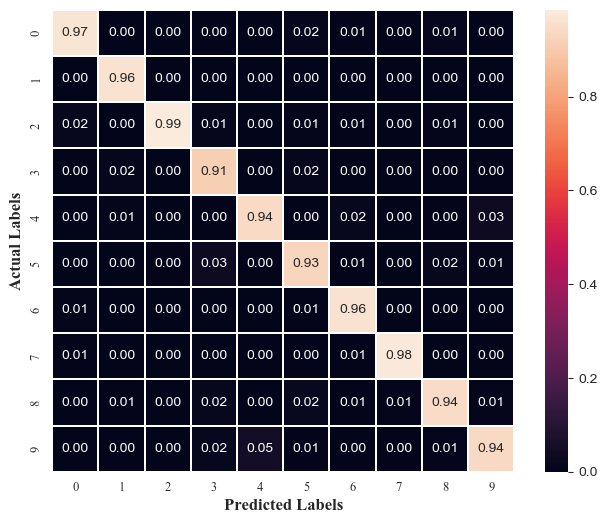

In [46]:
plt.figure(figsize = (8, 6))
sns.heatmap(confusion_matrix(true_labels, predictions, normalize = 'pred'), annot = True, fmt = "1.2f", linewidth = 0.01, square = True)
plt.xlabel("Predicted Labels", font = font_label)
plt.ylabel("Actual Labels", font = font_label)
plt.xticks(font = font)
plt.yticks(font = font)
plt.savefig("./Figures/11_PYTORCH_CM.png", dpi = 300, bbox_inches = 'tight')
plt.show()